### Описание проекта:
В рамках проекта у нас была поставлена задача создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней. Мы работали с информацией по трём интернет-магазинам различных категорий и анализировали обезличенную историю покупок клиентов за определенный период. Проект включал предсказание как на статичных данных, так и на временных рядах с использованием моделей keras, включающих слой LSTM.

In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import catboost
import time

from tqdm import tqdm
from keras.models import Model
from keras.layers import LSTM, Dense, Masking, Input, Concatenate, Reshape
from keras.metrics import AUC
from keras.utils import pad_sequences, plot_model, set_random_seed
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l1,l2
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from catboost import CatBoostClassifier, Pool, cv
warnings.filterwarnings("ignore")

In [155]:
MASK_VALUE = -1
set_random_seed(42)
np.random.seed(42)

In [156]:
#Даты выходных дней 22-23

is_holiday_22_23 = pd.to_datetime([
    "2022-01-01", "2022-01-02", "2022-01-03", "2022-01-04", "2022-01-05", "2022-01-06", "2022-01-08", "2022-01-07",
    "2022-02-23", "2022-03-08", "2022-05-01", "2022-05-02", "2022-05-09", "2022-06-12", "2022-06-13", "2022-11-04",
    "2023-01-01", "2023-01-02", "2023-01-03", "2023-01-04", "2023-01-05", "2023-01-06", "2023-01-08", "2023-01-07",
    "2023-02-23", "2023-03-08", "2023-05-01", "2023-05-09", "2023-06-12", "2023-11-04", "2023-02-24", "2023-05-08",
    "2023-11-06"
])

- marketplace - мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц;
- apparel - магазин одежды, по характеристикам похожий на маркетплейс;
- gifts – магазин подарков, очень маленький;
- client_id – идентификатор клиента;
- quantity – количество товара в заказе;
- price – цена 1 единицы товара в заказе;
- message_id – идентификатор сообщения из рассылки;
- date – дата покупки;

🔸изучить предоставленные данные
🔸создать полезные признаки для обучения модели
🔸создать целевой признак
🔸предложить и обосновать метрику
🔸обучить модель
🔸протестировать и проверить

In [157]:
data_apparel_purchases = pd.read_csv('D:\\\Masterskaya\\market_place\\data\\apparel-purchases.csv')
data_gifts_purchases = pd.read_csv('D:\\\Masterskaya\\market_place\\data\\gifts-purchases.csv')
data_marketplace_purchases = pd.read_csv('D:\\\Masterskaya\\market_place\\data\\marketplace-purchases.csv')

In [158]:
print(data_apparel_purchases.shape)
data_apparel_purchases.head(1)

(133104, 6)


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


### Функция для визуализации количества и объема продаж, а так же числа покупателей 

In [159]:
def plot_sales_statistics(data):
    # Преобразование столбца 'date' в тип datetime
    data['date'] = pd.to_datetime(data['date'])

    # Извлечение месяца из столбца 'date'
    data['month'] = data['date'].dt.to_period('M')

    # Группировка данных по месяцам и подсчет числа продаж
    sales_per_month = data.groupby('month').size().reset_index(name='count')

    # Группировка данных по месяцам и вычисление суммы цен продаж
    total_sales_per_month = data.groupby('month')['price'].sum().reset_index(name='total_price')
    
    plt.style.use('dark_background')
    plt.rcParams.update({"grid.linewidth":0.3, "grid.alpha":0.5})
    # Создание общего рисунка и подграфиков
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Построение графика числа продаж по месяцам
    sns.barplot(x='month', y='count', data=sales_per_month, color='skyblue', ax=ax1)
    ax1.set_title('Количество  продаж за месяц')
    ax1.set_xticklabels(sales_per_month['month'], rotation=45)
    ax1.set_xlabel('Месяц')
    ax1.set_ylabel('Количество продаж')

    # Построение графика суммарной стоимости продаж по месяцам
    sns.barplot(x='month', y='total_price', data=total_sales_per_month, color='salmon', ax=ax2)
    ax2.set_title('Ежемесячный объем продаж')
    ax2.set_xticklabels(total_sales_per_month['month'], rotation=45)
    ax2.set_xlabel('Месяц')
    ax2.set_ylabel('Сумма продаж за месяц')
    
    data['date'] = pd.to_datetime(data['date'])
    data['month'] = data['date'].dt.to_period('M')

    # Найдем новых клиентов для каждого месяца
    first_purchase_per_customer = data.groupby('client_id')['month'].min().reset_index()
    new_customers_per_month = first_purchase_per_customer.groupby('month').size().reset_index(name='new_customers')
    #new_customers_per_month = data.drop_duplicates('client_id').groupby('month').size().reset_index(name='new_customers')

    # Найдем общее количество клиентов для каждого месяца
    total_customers_per_month = data.groupby('month')['client_id'].nunique().reset_index(name='total_customers')

    # Объединим данные по новым и общим клиентам
    customers_data = pd.merge(total_customers_per_month, new_customers_per_month, on='month')

    sns.set_color_codes("pastel")
    sns.barplot(x='month', y='new_customers', data=customers_data, label='Новые покупатели', color='b', alpha=0.7, ax=ax3)

    sns.set_color_codes("muted")
    sns.barplot(x='month', y='total_customers', data=customers_data, label='Всего покупателей', color='b', alpha=0.7, ax=ax3)

    ax3.set_title('Уникальные покупатели и новые покупатели')
    ax3.set_xticklabels(total_sales_per_month['month'], rotation=45)
    ax3.set_xlabel('Месяц')
    ax3.set_ylabel('Количество покупателей')
    ax3.legend(loc='upper left', frameon=False)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4)  # Увеличиваем расстояние между подграфиками
    plt.show()

In [160]:
data_apparel_purchases['recommended_by'].value_counts()

recommended_by
bulk_message    133104
Name: count, dtype: int64

(133104, 6)


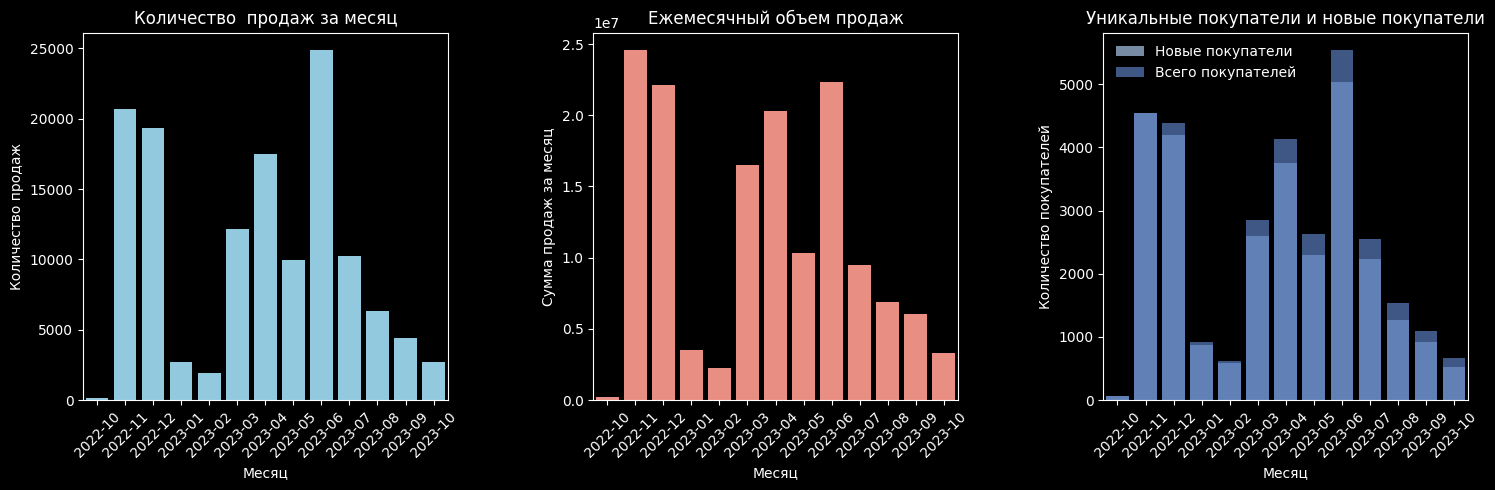

Timestamp('2022-10-26 00:00:00')

Timestamp('2023-10-26 00:00:00')

,client_id,quantity,price,date,message_id,recommended_by,month
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message,2023-09


In [161]:
print(data_apparel_purchases.shape)
plot_sales_statistics(data_apparel_purchases)
display(data_apparel_purchases['date'].min(), data_apparel_purchases['date'].max())
data_apparel_purchases.head(1)

(811, 6)


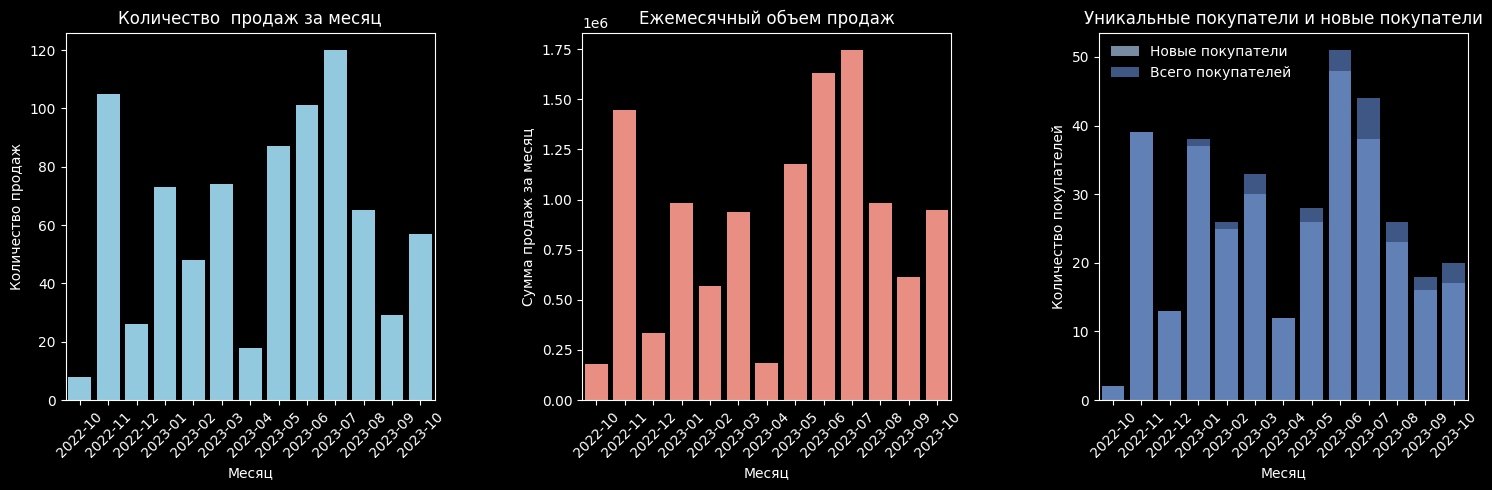

Timestamp('2022-10-26 00:00:00')

Timestamp('2023-10-24 00:00:00')

,client_id,quantity,price,date,message_id,recommended_by,month
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message,2023-10


In [162]:
print(data_gifts_purchases.shape)
plot_sales_statistics(data_gifts_purchases)
display(data_gifts_purchases['date'].min(), data_gifts_purchases['date'].max())
data_gifts_purchases.head(1)

(48182, 6)


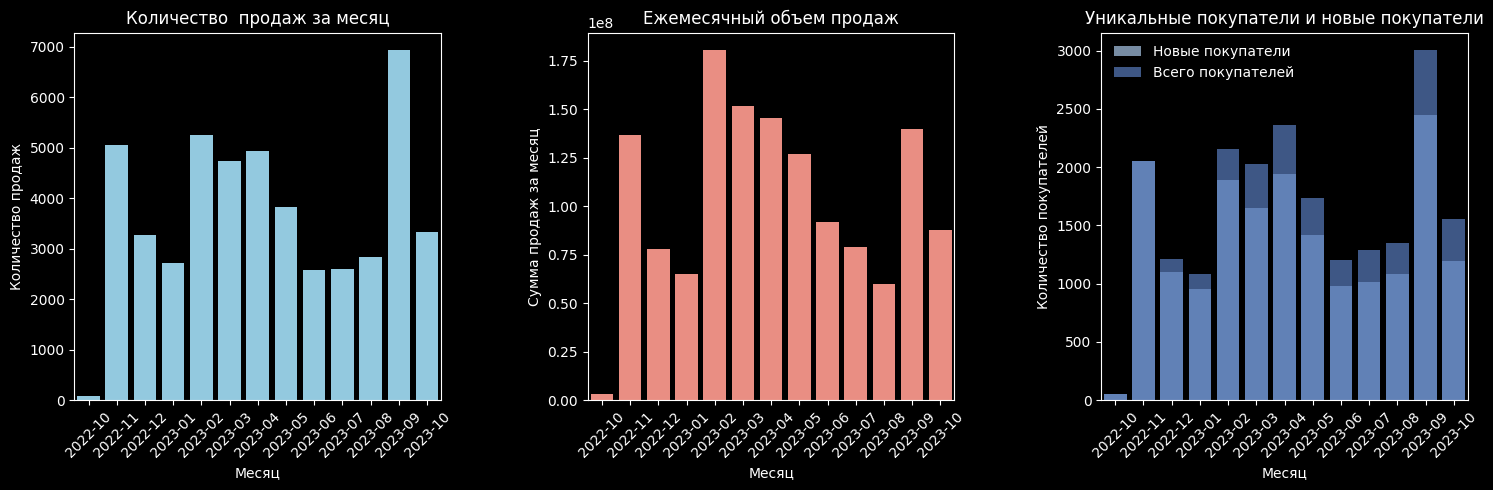

Timestamp('2022-10-26 08:35:46')

Timestamp('2023-10-26 13:34:11')

,client_id,quantity,price,message_id,created_at,date,month
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57,2023-05


In [163]:
print(data_marketplace_purchases.shape)
plot_sales_statistics(data_marketplace_purchases)
display(data_marketplace_purchases['date'].min(), data_marketplace_purchases['date'].max())
data_marketplace_purchases.head(1)

In [164]:
# data_marketplace_purchases['date'] = data_marketplace_purchases['date'].dt.date

In [165]:
# # Удаление столбцов 'date' и 'created_at'
# data_marketplace_purchases = data_marketplace_purchases.drop(['created_at'], axis=1)

In [166]:
# Объединим таблицы и добавим колонку категории магазина.

data_apparel_purchases['store_category_id'] = 1
data_marketplace_purchases['store_category_id'] = 2
data_gifts_purchases['store_category_id'] = 3

# Объединение таблиц
combined_data = pd.concat([data_apparel_purchases, data_marketplace_purchases, data_gifts_purchases], ignore_index=True).copy()

(182097, 9)


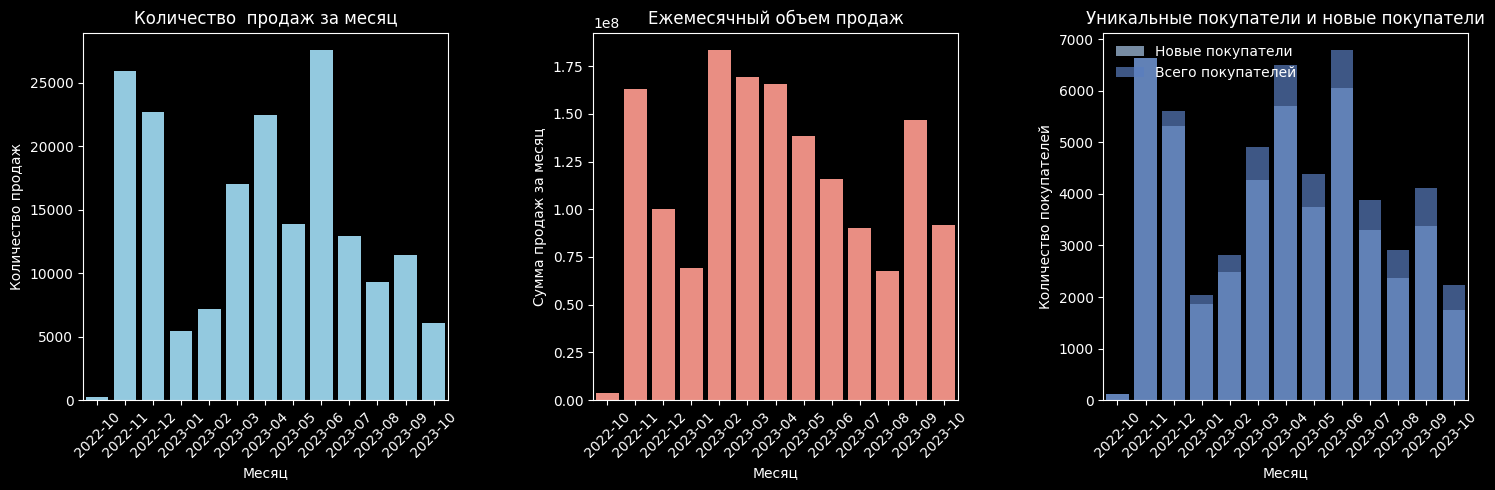

,client_id,quantity,price,date,message_id,recommended_by,month,store_category_id,created_at
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message,2023-09,1,NaN


In [167]:
print(combined_data.shape)
plot_sales_statistics(combined_data)
combined_data.head(1)

In [168]:
combined_data['message_id'].value_counts().sum

<bound method Series.sum of message_id
1515915625489095763-6251-6311b13a4cf78     271
1515915625624308268-7803-636dfea7ca890     218
1515915625557752721-1909-64942a0b0e7f5     180
1515915625880116527-8725-639b2f0ad5e2e     160
1515915625607113301-13818-650a8af70fd67    148
                                          ... 
1515915625536120644-1985-64b8c802294a5       1
1515915625685286173-8033-637dbe2e0c234       1
1515915625536533267-1965-64abd0808d6c9       1
1515915625536556344-1964-64a54c3f45b1f       1
1515915625524007589-2141-651bad036f2f8       1
Name: count, Length: 46708, dtype: int64>

Стоит учитывать признак message_id в модели, так как он имеет много уникальных значений с разной частотой в данных. Это может помочь модели выявить скрытые паттерны и лучше предсказывать результаты. 
Закодируем message_id в числовой формат     


In [169]:
# Кодирование message_id в числовой формат
encoder = LabelEncoder()
combined_data['message_id_encoded'] = encoder.fit_transform(combined_data['message_id'])

# Удаление исходного столбца message_id
combined_data.drop('message_id', axis=1, inplace=True)

In [170]:
combined_data['recommended_by'].value_counts()

recommended_by
bulk_message    133915
Name: count, dtype: int64

In [171]:
# recommended_by не несет смысла, drop
combined_data = combined_data.drop(columns=['recommended_by','month'])

In [172]:
combined_data[combined_data.duplicated()]

,client_id,quantity,price,date,store_category_id,created_at,message_id_encoded
1,1515915625468068833,1,3499.0,2023-09-08,1,NaN,1363
2,1515915625468068833,1,3499.0,2023-09-08,1,NaN,1363
4,1515915625468068833,1,2450.0,2023-09-08,1,NaN,1363
5,1515915625468068833,1,2450.0,2023-09-08,1,NaN,1363
10,1515915625468079941,1,1499.0,2023-09-01,1,NaN,1474
...,...,...,...,...,...,...,...
182079,1515915625862783809,1,5194.0,2022-11-08,3,NaN,44023
182080,1515915625862783809,1,5194.0,2022-11-08,3,NaN,44023
182081,1515915625862783809,1,5194.0,2022-11-08,3,NaN,44023
182084,1515915625864817073,1,1893.0,2022-11-11,3,NaN,44106


Будем считать, что дубликаты это множественные заказы или различные товары в один день.     
Агрегируем - объединим данные для дубликатов, суммируем количество и цену товаров. 

### Модель времянного ряда

In [173]:
data_grouped = combined_data.groupby(['client_id', 'date', 'store_category_id']).agg({'quantity': 'sum', 'price': 'sum', 'message_id_encoded': 'first'}).reset_index()
data_grouped.shape

(65576, 6)

In [174]:
data_grouped

,client_id,date,store_category_id,quantity,price,message_id_encoded
0,1515915625440099873,2023-07-16 08:25:31,2,1,31998.0,0
1,1515915625440099873,2023-08-09 08:59:08,2,1,1218.0,1
2,1515915625440939402,2023-01-30 13:13:37,2,1,75998.0,2
3,1515915625440944408,2023-03-01 10:21:12,2,1,882.0,3
4,1515915625440944408,2023-05-02 08:49:57,2,1,6298.0,4
...,...,...,...,...,...,...
65571,1515915626005014483,2023-09-13 00:00:00,3,1,7534.0,45265
65572,1515915626010039507,2023-10-02 00:00:00,3,2,26039.0,46706
65573,1515915626011484905,2023-10-13 00:00:00,3,5,32913.0,46707
65574,1515915626012131867,2023-09-12 00:00:00,3,1,25834.0,43719


In [175]:
# Сортировка данных по клиенту и дате
data_grouped = data_grouped.sort_values(['client_id', 'date'])

Создадим временные признаки, например, RFM (Recency, Frequency, Monetary) нарастающим итогом:

In [176]:
# Рассчитаем RFM нарастающим итогом
data_grouped['monetary'] = data_grouped.groupby('client_id')['price'].cumsum()
data_grouped['recency'] = data_grouped.groupby('client_id')['date'].diff().dt.days.fillna(999).astype(int)
data_grouped['frequency'] = data_grouped.groupby('client_id')['date'].cumcount() + 1

Рассчитаем разницу в датах для каждого клиента и получим количество дней до следующей покупки с помощью сдвига:

In [177]:
# data_grouped['days_to_next_purchase'] = data_grouped.groupby('client_id')['date'].diff().dt.days
data_grouped['days_to_next_purchase'] = -data_grouped.sort_values('date', ascending=False).groupby('client_id')['date'].diff().dt.days

Создадим целевую переменную, где 1 означает повторную покупку в течение 30 дней после заказа:

In [178]:
data_grouped['target'] = (data_grouped['days_to_next_purchase'] <= 30).astype(int)

In [179]:
data_grouped = data_grouped.sort_values(['date'])

In [180]:
# Найдем дату, на которую нужно удалить последние 30 дней
date_to_exclude = data_grouped['date'].max() - pd.Timedelta(days=30)

# Удалим данные за последние 30 дней
data_grouped = data_grouped[data_grouped['date'] < date_to_exclude]

In [181]:
data_grouped['frequency'].value_counts()

frequency
1      44678
2       8305
3       3016
4       1461
5        858
       ...  
120        1
121        1
122        1
123        1
144        1
Name: count, Length: 144, dtype: int64

In [182]:
# Скопировать data_grouped в features_time_s
features_time_s = data_grouped.copy()

# Создание признаков "день месяца", "день недели", "неделя месяца" и "является ли день выходным"
features_time_s['total_price'] = features_time_s['price'] * features_time_s['quantity']
features_time_s['day_of_month'] = features_time_s['date'].dt.day
features_time_s['day_of_week'] = features_time_s['date'].dt.dayofweek
features_time_s['month'] = features_time_s['date'].dt.month
features_time_s['week_of_year'] = features_time_s['date'].dt.isocalendar().week
features_time_s['week_of_month'] = features_time_s['date'].apply(lambda x: (x.day - 1) // 7 + 1)
features_time_s['is_weekend'] = features_time_s['day_of_week'].isin([5, 6]).astype(int)
features_time_s['is_holiday'] = features_time_s['date'].isin(is_holiday_22_23).astype(int)

# Создаем список дат на следующие 30 дней от каждой даты в features_time_s
date_ranges = [pd.date_range(date, periods=30) for date in features_time_s['date']]
# Создаем новый признак 'holidays_next_30_days'
features_time_s['holidays_next_30_days'] = [sum(1 for holiday in is_holiday_22_23 if holiday in date_range) for date_range in date_ranges]

In [183]:
features_time_s = features_time_s.set_index('date')
# Удалить время из даты в индексе, оставить только дату
features_time_s.index = features_time_s.index.date
features_time_s.head(3)

,client_id,store_category_id,quantity,price,message_id_encoded,monetary,recency,frequency,days_to_next_purchase,target,total_price,day_of_month,day_of_week,month,week_of_year,week_of_month,is_weekend,is_holiday,holidays_next_30_days
2022-10-26,1515915625587818098,1,2,17998.0,9575,17998.0,999,1,NaN,0,35996.0,26,2,10,43,4,0,0,1
2022-10-26,1515915625588327029,1,1,2499.0,37963,2499.0,999,1,NaN,0,2499.0,26,2,10,43,4,0,0,1
2022-10-26,1515915625489888679,1,3,2213.0,9134,2213.0,999,1,NaN,0,6639.0,26,2,10,43,4,0,0,1


In [184]:
# Определяем целевой признак
X = features_time_s.drop(['client_id', 'days_to_next_purchase', 'total_price', 'target'], axis=1)
y = features_time_s['target']

In [185]:
display(features_time_s['target'].value_counts().to_frame().assign(percentage=lambda x: x/x.sum()).style.format({'percentage':'{:.2%}', 'target':'{:.0f}'}).set_caption('Распределение классов'))
print(y.shape)

,count,percentage
target,,
0,48579,79.01%
1,12908,20.99%


(61487,)


In [186]:
# # Сетка параметров для подбора
# grid = {'learning_rate': [0.15],
#         'depth': [8,10],
#         'l2_leaf_reg': [1, 2],}

# # Инициализация модели CatBoost с использованием GPU
# model = CatBoostClassifier(iterations=1000, task_type='GPU', devices='0:1', verbose=False) 

# # Подбор лучших параметров с помощью Grid Search
# grid_search_result = model.grid_search(grid, X=Pool(X_train, label=y_train), plot=True)

# # Получение лучших параметров
# best_params = grid_search_result['params']

# # Создание модели с лучшими параметрами и использованием GPU
# best_model = CatBoostClassifier(iterations=1000, task_type='GPU', devices='0:1', verbose=False, **best_params)

In [187]:
best_params = {'depth': 8,
 'od_wait': 50,
 'l2_leaf_reg': 1,
 'iterations': 1000,
 'learning_rate': 0.05}

{'depth': 10, 'l2_leaf_reg': 2, 'learning_rate': 0.15}

In [188]:
best_model = CatBoostClassifier(verbose=False, **best_params, random_seed=42)

In [189]:
num_days = features_time_s.index.nunique()
print("Number of days in the dataset: ", num_days)

Number of days in the dataset:  336


In [190]:
# Создаем объект TimeSeriesSplit
n_splits = 11
tscv = TimeSeriesSplit(n_splits=n_splits)


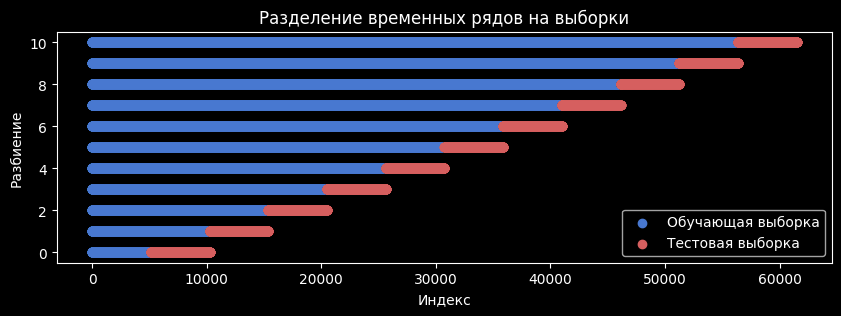

In [191]:
# Визуализируем разделение на выборки
plt.figure(figsize=(10, 3))
for i, (train_index, test_index) in enumerate(tscv.split(features_time_s)):
    plt.scatter(train_index, [i]*len(train_index), color='b', label='Обучающая выборка' if i==0 else "")
    plt.scatter(test_index, [i]*len(test_index), color='r', label='Тестовая выборка' if i==0 else "")

plt.xlabel('Индекс')
plt.ylabel('Разбиение')
plt.title('Разделение временных рядов на выборки')
plt.legend()
plt.show()

In [192]:
# Обучаем модель с использованием TimeSeriesSplit
for train_index, test_index in tqdm(tscv.split(X), total=tscv.get_n_splits()):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    start_time = time.time()  # Замеряем время начала обучения
    best_model.fit(X_train, y_train) 
    end_time = time.time()  # Замеряем время окончания обучения
    
    # Выводим время обучения текущей итерации
    print(f"Время обучения: {end_time - start_time} секунд")

  9%|▉         | 1/11 [00:04<00:46,  4.70s/it]

Время обучения: 4.6911537647247314 секунд


 18%|█▊        | 2/11 [00:13<01:03,  7.01s/it]

Время обучения: 8.622242212295532 секунд


 27%|██▋       | 3/11 [00:22<01:05,  8.17s/it]

Время обучения: 9.553581476211548 секунд


 36%|███▋      | 4/11 [00:32<01:01,  8.82s/it]

Время обучения: 9.798789024353027 секунд


 45%|████▌     | 5/11 [00:42<00:55,  9.24s/it]

Время обучения: 9.976540803909302 секунд


 55%|█████▍    | 6/11 [00:53<00:48,  9.75s/it]

Время обучения: 10.740658283233643 секунд


 64%|██████▎   | 7/11 [01:04<00:40, 10.14s/it]

Время обучения: 10.932017087936401 секунд


 73%|███████▎  | 8/11 [01:15<00:31, 10.41s/it]

Время обучения: 10.996756315231323 секунд


 82%|████████▏ | 9/11 [01:26<00:21, 10.66s/it]

Время обучения: 11.187750101089478 секунд


 91%|█████████ | 10/11 [01:38<00:10, 10.92s/it]

Время обучения: 11.492672681808472 секунд


100%|██████████| 11/11 [01:49<00:00, 10.00s/it]

Время обучения: 11.935496807098389 секунд


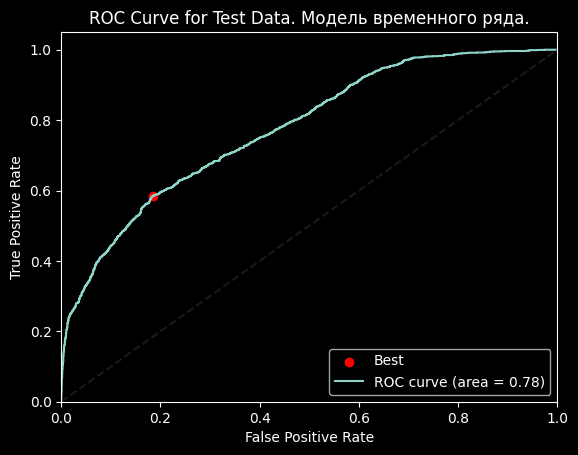

best threshold 0.284
ROC AUC на тестовой выборке: 0.7758074349504938


,0,1,accuracy,macro avg,weighted avg
precision,0.81,0.60,0.74,0.7,0.74
recall,0.81,0.58,0.74,0.7,0.74
f1-score,0.81,0.59,0.74,0.7,0.74
support,3487.00,1636.00,0.74,5123.0,5123.00


In [193]:
y_pred = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)

# Построение ROC-AUC кривой для тестового набора данных
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
idx = np.argmax(tpr - fpr)
best_thresh = thresholds[idx]
plt.figure()
plt.scatter(fpr[idx], tpr[idx], marker="o", color="red", label="Best")
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data. Модель временного ряда.')
plt.legend(loc="lower right")
plt.show()

# Предсказываем на тестовой выборке и вычисляем ROC AUC
y_pred_class = best_model.predict(X_test)
roc_auc_test = roc_auc_score(y_test, y_pred)
print('best threshold', best_thresh.round(3))
print(f'ROC AUC на тестовой выборке: {roc_auc_test}')

report = classification_report(y_test, y_pred > best_thresh, output_dict=True)
df_report = pd.DataFrame(report).round(2)
df_report

Метрика precision класса 1 равная 0.6 указывает на то, что из всех предсказанных как класс 1 (покупатель совершит повторную покупку), только 60% действительно являются классом 1.   
Метрика recall класса 1 равный 0.58, означает, что  модель верно классифицирует 65% всех истинных случаев принадлежности к классу 1 среди всех случаев, которые действительно принадлежат к классу 1.

Стоит учесть, что когда модель предсказывает с высокой уверенностью, что определенные клиенты совершат повторные покупки (класс 1) и при этом она довольно точна в своих прогнозах, то в данном случае стимулирование этих клиентов может быть не столь эффективным, так как они, скорее всего, все равно сделают покупку.

В этом случае стоит рассмотреть некоторые альтернативные стратегии, например:

- Сосредоточиться на привлечении и удержании клиентов, для которых модель предсказывает менее высокую вероятность повторной покупки (класс 0).
- Использовать информацию о вероятности повторной покупки как фактор в динамической адаптации стратегий взаимодействия с клиентами.
- Разработать программы лояльности или персонализированные предложения, которые будут нацелены на клиентов с низкой вероятностью повторной покупки.
- Важно сбалансировать стратегии стимулирования клиентов и учитывать не только вероятности, предсказанные моделью, но и другие факторы, такие как ценность клиента, его потенциальность для лояльности и другие цели бизнеса. 

In [194]:
# Важность признаков
feature_importance = best_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print('Важность признаков:')
print(feature_importance_df)

Важность признаков:
                  Feature  Importance
3      message_id_encoded   14.450871
2                   price   11.451959
4                monetary   11.034312
0       store_category_id    9.453266
10           week_of_year    9.187495
7            day_of_month    8.599270
8             day_of_week    7.557319
1                quantity    6.305260
5                 recency    6.300844
6               frequency    5.691102
9                   month    3.393107
14  holidays_next_30_days    3.292479
11          week_of_month    1.958043
12             is_weekend    0.959903
13             is_holiday    0.364770


Похоже, признак message_id_encoded имеет высокий вес (14.25), что указывает на его значимость для модели. Этот признак может оказать значительное влияние на предсказания.      
Остальные признаки также важны, особенно price, monetary, store_category_id и другие, каждый вносит свой вклад в прогнозирование целевой переменной. 

### Обучим модель keras с LSTM

In [195]:
combined_data

,client_id,quantity,price,date,store_category_id,created_at,message_id_encoded
0,1515915625468068833,1,3499.0,2023-09-08,1,NaN,1363
1,1515915625468068833,1,3499.0,2023-09-08,1,NaN,1363
2,1515915625468068833,1,3499.0,2023-09-08,1,NaN,1363
3,1515915625468068833,1,2450.0,2023-09-08,1,NaN,1363
4,1515915625468068833,1,2450.0,2023-09-08,1,NaN,1363
...,...,...,...,...,...,...,...
182092,1515915625870025628,1,39992.0,2022-11-28,3,NaN,44215
182093,1515915625873498326,1,3035.0,2022-11-23,3,NaN,44267
182094,1515915625873498326,1,3035.0,2022-11-23,3,NaN,44267
182095,1515915625878133961,1,3442.0,2022-11-26,3,NaN,44191


In [196]:
data_grouped_seq = combined_data

# Добавляем поле total
data_grouped_seq['total'] = data_grouped_seq['price'] * data_grouped_seq['quantity']
combined_data['month'] = combined_data['date'].dt.month
combined_data['day_of_week'] = combined_data['date'].dt.dayofweek
combined_data['day'] = combined_data['date'].dt.day
combined_data['quarter'] = combined_data['date'].dt.quarter

data_grouped_seq = data_grouped_seq.sort_values(by='date')

# Группировка и добавление поля since_prev_purchase
data_grouped_seq['monetary'] = data_grouped_seq.groupby('client_id')['price'].cumsum()
data_grouped_seq['recency'] = data_grouped_seq.groupby('client_id')['date'].diff().dt.days.fillna(999).astype(int)
data_grouped_seq['frequency'] = data_grouped_seq.groupby('client_id')['date'].cumcount() + 1



In [197]:
data_grouped_seq

,client_id,quantity,price,date,store_category_id,created_at,message_id_encoded,total,month,day_of_week,day,quarter,monetary,recency,frequency
42188,1515915625558655965,1,767.0,2022-10-26 00:00:00,1,NaN,30102,767.0,10,2,26,4,767.0,999,1
181497,1515915625857065470,1,36720.0,2022-10-26 00:00:00,3,NaN,43294,36720.0,10,2,26,4,36720.0,999,1
181496,1515915625857065470,1,54040.0,2022-10-26 00:00:00,3,NaN,43294,54040.0,10,2,26,4,90760.0,0,2
181495,1515915625857065470,1,59990.0,2022-10-26 00:00:00,3,NaN,43294,59990.0,10,2,26,4,150750.0,0,3
58333,1515915625587818098,1,7999.0,2022-10-26 00:00:00,1,NaN,9575,7999.0,10,2,26,4,7999.0,999,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157604,1515915625587268787,1,298.0,2023-10-26 11:23:08,2,2023-10-26,37881,298.0,10,3,26,4,298.0,999,1
157605,1515915625588069308,1,7780.0,2023-10-26 12:43:55,2,2023-10-26,37950,7780.0,10,3,26,4,7780.0,999,1
157606,1515915625588069308,1,3980.0,2023-10-26 12:43:55,2,2023-10-26,37950,3980.0,10,3,26,4,11760.0,0,2
157598,1515915625581725735,1,77978.0,2023-10-26 13:15:32,2,2023-10-26,37081,77978.0,10,3,26,4,77978.0,999,1


In [198]:
# # Выборка нужных столбцов
# data_grouped_seq = data_grouped_seq[['client_id','date', 'message_id_encoded', 'total', 'since_prev_purchase']]
# data_grouped_seq = data_grouped_seq[['client_id','date', 'message_id_encoded', 'price', 'quantity', 'since_prev_purchase]']
data_grouped_seq = data_grouped_seq[['client_id','date', 'message_id_encoded', 'total', 'monetary', 'recency', 'frequency', 'month', 'day_of_week', 'day', 'quarter']]

Для каждого клиента вычислим аккумулированные значения (суммы) значений до каждой даты включительно.

In [199]:
scaler = MinMaxScaler(feature_range=(0, 1))

features_to_scale = ['total', 'monetary', 'recency', 'frequency', 'month', 'day_of_week', 'message_id_encoded', 'day', 'quarter']
scaled_names = [f'{col}_scaled' for col in features_to_scale]
data_grouped_seq[scaled_names] = scaler.fit_transform(data_grouped_seq[features_to_scale])

def aggregate_sequences(group):
    aggregated_values = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    cumulated_sequence = 0
    for value in group[::-1]:  # Идем по значениям в обратном порядке
        cumulated_sequence += value
        aggregated_values.pop(0)  # Удаляем старое значение
        aggregated_values.append(cumulated_sequence)  # Добавляем новое значение
    return aggregated_values


# Группировка данных по 'client_id' и 'date' с агрегацией в формате последовательностей
features_seq = (data_grouped_seq.groupby(['client_id', 'date'])[scaled_names]
                .agg(aggregate_sequences).add_suffix('_seq').reset_index())


In [200]:
# Отсортируем по дате
features_seq = features_seq.sort_values(by='date')

In [201]:
# Удалим данные за последние 30 дней
features_seq = features_seq[features_seq['date'] < date_to_exclude]

In [202]:
features_seq.shape

(61487, 11)

In [203]:
features_seq = features_seq.set_index('date')
features_seq.index = pd.to_datetime(features_seq.index)
# Удалить время из даты в индексе
features_seq.index = features_seq.index.date

In [204]:
filtered_features_seq = features_seq.drop(['client_id'], axis=1)

In [205]:
# Получаем все длины последовательностей

seq_len = filtered_features_seq
all_lengths = []
for column in seq_len.columns:
    all_lengths.extend(seq_len[column].apply(lambda x: len(x) if isinstance(x, list) else 0))

# Определяем квартили
Q1 = pd.Series(all_lengths).quantile(0.25)
Q3 = pd.Series(all_lengths).quantile(0.75)
IQR = Q3 - Q1

# Определяем границы для определения выбросов
lower_bound = 0
upper_bound = Q3 + 1.5 * IQR

print(f'Нижняя граница для выбросов: {lower_bound}')
print(f'Верхняя граница для выбросов: {upper_bound}')

Нижняя граница для выбросов: 0
Верхняя граница для выбросов: 10.0


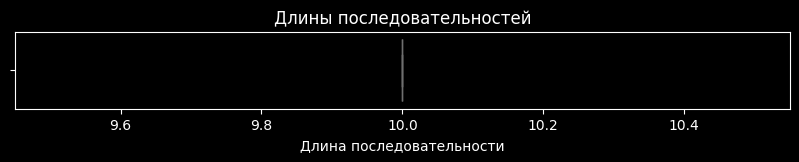

In [206]:
df = filtered_features_seq

# Получаем все длины последовательностей
all_lengths = []
for column in df.columns:
    all_lengths.extend(df[column].apply(lambda x: len(x) if isinstance(x, list) else 0))

# Построение ящика с усами для длин последовательностей
plt.figure(figsize=(10, 1))
sns.boxplot(data=all_lengths, orient='h', color='skyblue')

plt.xlabel('Длина последовательности')
plt.title('Длины последовательностей')
plt.show()



In [207]:
# Выравнивание последовательностей с использованием встроенной функции
X_seq = np.concatenate([
    pad_sequences(filtered_features_seq[col].values, dtype='float', value=MASK_VALUE, padding='post')[:, :, np.newaxis]
    for col in filtered_features_seq.columns
], axis=2)

In [208]:
# Нормализация X_time_s
scaler_time_s = MinMaxScaler(feature_range=(0, 1))
X_time_s = scaler_time_s.fit_transform(features_time_s.drop(['client_id','days_to_next_purchase','target'], axis=1))

X_seq.shape, X_time_s.shape

((61487, 10, 9), (61487, 16))

In [209]:
# Разделение на обучающую и тестовую выборку
X_train_seq, X_test_seq, X_train_time_s, X_test_time_s, y_train, y_test = train_test_split(
    X_seq, X_time_s, y, test_size=0.2, random_state=42, shuffle=False)

y = data_grouped['target']
display(data_grouped['target'].value_counts().to_frame().assign(percentage=lambda x: x/x.sum()).style.format({'percentage':'{:.2%}', 'target':'{:.0f}'}).set_caption('Распределение классов'))
y = y.values

y.shape

,count,percentage
target,,
0,48579,79.01%
1,12908,20.99%


(61487,)

In [210]:
from tensorflow.keras.layers import Bidirectional

In [212]:
# Определение входных данных
input_seq = Input(shape=(X_train_seq.shape[1:]))
input_time_s = Input(shape=(X_train_time_s.shape[1],))

# Слой маскирования для input_seq
masked_seq = Masking(mask_value=MASK_VALUE)(input_seq)
#bilstm_seq = Bidirectional(LSTM(32, kernel_regularizer=l1(0.01), recurrent_regularizer=l2(0.01), activity_regularizer=l2(0.01)))(masked_seq)
module_seq = LSTM(32, kernel_regularizer=l1(0.01), recurrent_regularizer=l2(0.01), activity_regularizer=l2(0.01))(masked_seq)

# Плотный слой для input_time_s
dense_time_s = Dense(16, activation='relu')(input_time_s)

# Сцепление выходных данных
concatenated = Concatenate()([module_seq, dense_time_s])

# Слой выходных данных
output = Dense(1, activation='sigmoid')(concatenated)

# Создание модели
model = Model(inputs=[input_seq, input_time_s], outputs=output)

# Компиляция модели
opt = Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])

# Добавление обратных вызовов для отслеживания процесса обучения
callbacks = [
    ModelCheckpoint(filepath='best_model.h5', monitor='val_auc', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

# Обучение модели
history = model.fit(x=[X_train_seq, X_train_time_s], y=y_train, validation_split=0.2, epochs=14, batch_size=32, callbacks=callbacks, shuffle=False)

# Оценка модели
loss, auc = model.evaluate([X_test_seq, X_test_time_s], y_test)
print(f'Тестовая ошибка: {loss}, Тестовая AUC: {auc}')




Epoch 1/14

1230/1230 [==============================] - 10s 5ms/step - loss: 0.4713 - auc: 0.7739 - val_loss: 0.3491 - val_auc: 0.7854
Epoch 2/14
1230/1230 [==============================] - 5s 4ms/step - loss: 0.4409 - auc: 0.7881 - val_loss: 0.3465 - val_auc: 0.7859
Epoch 3/14
1230/1230 [==============================] - 6s 5ms/step - loss: 0.4376 - auc: 0.7904 - val_loss: 0.3459 - val_auc: 0.7868
Epoch 4/14
1230/1230 [==============================] - 5s 4ms/step - loss: 0.4361 - auc: 0.7919 - val_loss: 0.3452 - val_auc: 0.7860
Epoch 5/14
1230/1230 [==============================] - 5s 4ms/step - loss: 0.4352 - auc: 0.7924 - val_loss: 0.3451 - val_auc: 0.7862
Epoch 6/14
1230/1230 [==============================] - 5s 4ms/step - loss: 0.4348 - auc: 0.7931 - val_loss: 0.3465 - val_auc: 0.7839
Epoch 7/14
1230/1230 [==============================] - 5s 4ms/step - loss: 0.4346 - auc: 0.7936 - val_loss: 0.3465 - val_auc: 0.7839
Epoch 8/14
385/385 [==============================] - 1s 2

385/385 [==============================] - 2s 2ms/step


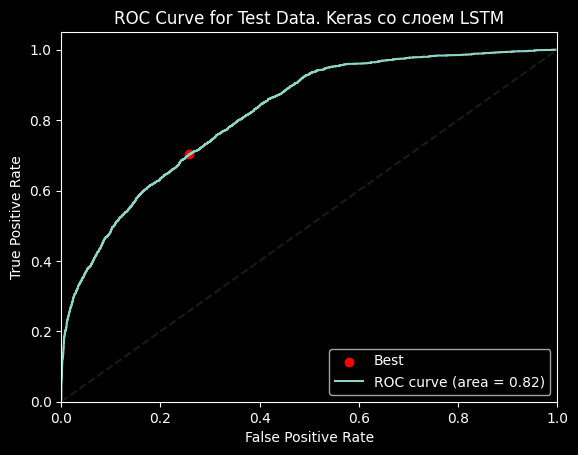

roc auc score 0.817
best threshold 0.27


,0,1,accuracy,macro avg,weighted avg
precision,0.89,0.45,0.73,0.67,0.79
recall,0.74,0.70,0.73,0.72,0.73
f1-score,0.81,0.55,0.73,0.68,0.75
support,9460.00,2838.00,0.73,12298.00,12298.00


In [213]:
y_pred = model.predict((X_test_seq, X_test_time_s)).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

idx = np.argmax(tpr - fpr)
best_thresh = thresholds[idx]

plt.figure()
plt.scatter(fpr[idx], tpr[idx], marker="o", color="red", label="Best")
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred).round(3))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data. Keras со слоем LSTM')
plt.legend(loc="lower right")
plt.show()

print('roc auc score', roc_auc_score(y_test, y_pred).round(3))
print('best threshold', best_thresh.round(3))
pd.DataFrame(classification_report(y_test, y_pred>(best_thresh), output_dict=True)).round(2)

In [ ]:

# scaler = MinMaxScaler(feature_range=(0, 1))

# features_to_scale = ['total', 'monetary', 'recency', 'frequency', 'month', 'day_of_week']
# scaled_names = [f'{col}_scaled' for col in features_to_scale]
# data_grouped_seq[scaled_names] = scaler.fit_transform(data_grouped_seq[features_to_scale])

# features_seq = (data_grouped_seq.groupby(['client_id', 'date'])[scaled_names]
#                   .agg(list).add_suffix('_seq').reset_index())

### Статичная модель

In [ ]:
# Сортируем данные по дате
combined_data = combined_data.sort_values('date')

# Ищем последние 30 дней в данных о покупках
data_last_30_days = combined_data[combined_data['date'] >= combined_data['date'].max() - pd.DateOffset(days=30)]

# Исключаем последние 30 дней из других данных
data_wo_last_30_days = combined_data[combined_data['date'] < combined_data['date'].max() - pd.DateOffset(days=30)]

# Создание основных признаков
grouped_data_static = data_wo_last_30_days.groupby(['client_id', 'store_category_id'])
current_date = data_wo_last_30_days['date'].max()
features_static = grouped_data_static.agg(
    days_since_first_purchase=('date', lambda x: (current_date - x.min()).days),
    days_since_last_purchase=('date', lambda x: (current_date - x.max()).days),
    days_between_purchases_min=('date', lambda x: (x.max() - x.min()).days if len(x) > 1 else -999),
    days_between_purchases_mean=('date', lambda x: x.diff().dt.days.sum() / (len(x) - 1) if len(x) > 1 else -999),
    days_between_purchases_max=('date', lambda x: x.diff().dt.days.max() if len(x) > 1 else -999),
    total_products_bought=('quantity', 'sum'),
    total_purchases=('date', 'nunique'),
    average_purchase_price=('price', 'mean'),
    max_purchase_price=('price', 'max'),
    min_purchase_price=('price', 'min'),
    total_spent=('price', 'sum'),
    preferred_day_of_week=('date', lambda x: x.dt.dayofweek.mode()[0]),
    preferred_week_of_year=('date', lambda x: x.dt.isocalendar().week.mode()[0]),
    preferred_week_of_month=('date', lambda x: np.ceil(x.dt.day / 7).mode()[0]),                        
    most_common_message_id=('message_id_encoded', lambda x: x.value_counts().idxmax())).reset_index()

# Присвоение таргета
target_client_ids = data_last_30_days['client_id'].unique()
features_static['target'] = features_static['client_id'].isin(target_client_ids).astype(int)

# Вывод полученных признаков
features_static

,client_id,store_category_id,days_since_first_purchase,days_since_last_purchase,days_between_purchases_min,days_between_purchases_mean,days_between_purchases_max,total_products_bought,total_purchases,average_purchase_price,max_purchase_price,min_purchase_price,total_spent,preferred_day_of_week,preferred_week_of_year,preferred_week_of_month,most_common_message_id,target
0,1515915625440099873,2,72,48,24,24.000000,24.0,2,2,16608.000000,31998.0,1218.0,33216.0,2,28,2.0,0,0
1,1515915625440939402,2,239,239,-999,-999.000000,-999.0,1,1,75998.000000,75998.0,75998.0,75998.0,0,5,5.0,2,0
2,1515915625440944408,2,209,97,112,55.500000,61.0,3,3,27059.333333,73998.0,882.0,81178.0,2,9,1.0,3,0
3,1515915625440947454,2,323,275,47,15.666667,47.0,4,2,1121.500000,3998.0,2.0,4486.0,5,44,1.0,6,0
4,1515915625440952940,2,319,319,-999,-999.000000,-999.0,1,1,479.000000,479.0,479.0,479.0,4,45,2.0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44673,1515915625996380624,3,27,27,0,0.000000,0.0,6,1,11708.500000,33732.0,4040.0,70251.0,2,35,5.0,46689,0
44674,1515915625997511191,3,39,39,-999,-999.000000,-999.0,1,1,15043.000000,15043.0,15043.0,15043.0,4,33,3.0,46698,0
44675,1515915625997770678,3,39,39,0,0.000000,0.0,5,1,20835.400000,47549.0,1909.0,104177.0,4,33,3.0,46699,0
44676,1515915626005014483,3,13,13,-999,-999.000000,-999.0,1,1,7534.000000,7534.0,7534.0,7534.0,2,37,2.0,45265,0


In [218]:
# Отделяем целевую переменную от признаков
X = features_static.drop(['client_id', 'target'], axis=1)
y = features_static['target']

# Переведем в int
np.int = int
y = y.astype(int)

# Разбиваем на обучающую и тестовую выборки
X_train_static, X_test_static, y_train_static, y_test_static = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [219]:
display(features_static['target'].value_counts().to_frame().assign(percentage=lambda x: x/x.sum()).style.format({'percentage':'{:.2%}', 'target':'{:.0f}'}).set_caption('Распределение классов'))
X.shape, y.shape

,count,percentage
target,,
0,44023,98.53%
1,655,1.47%


((44678, 16), (44678,))

In [220]:
model_static = CatBoostClassifier(verbose=False, **best_params, random_seed=42)  # best_params - параметры из предыдущих шагов
model_static.fit(X_train_static, y_train_static)

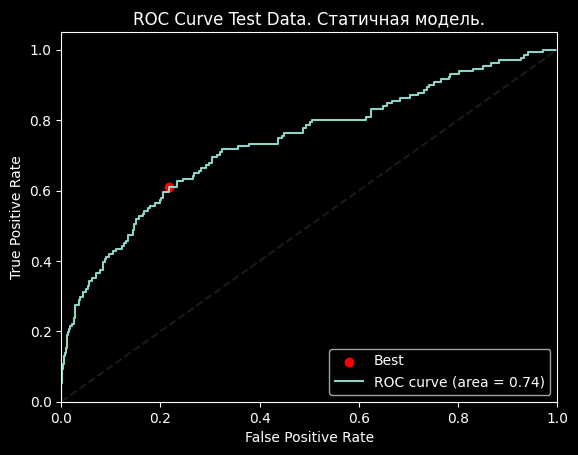

best threshold 0.006
ROC-AUC на тестовой выборке: 0.7373542964398264
                 0       1  accuracy  macro avg  weighted avg
precision     0.99    0.04      0.78       0.52          0.98
recall        0.78    0.60      0.78       0.69          0.78
f1-score      0.88    0.07      0.78       0.47          0.86
support    8805.00  131.00      0.78    8936.00       8936.00


In [224]:
# Предсказать вероятности для тестовой выборки
y_pred_static = model_static.predict_proba(X_test_static)[:, 1]
# Построение ROC-AUC кривой для тестового набора данных
fpr, tpr, thresholds = roc_curve(y_test_static, y_pred_static)
idx = np.argmax(tpr - fpr)
best_thresh = thresholds[idx]
# Вычислить ROC-AUC
roc_auc = roc_auc_score(y_test_static, y_pred_static)
plt.figure()
plt.scatter(fpr[idx], tpr[idx], marker="o", color="red", label="Best")
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Test Data. Статичная модель.')
plt.legend(loc="lower right")
plt.show()

print('best threshold', best_thresh.round(3))
print("ROC-AUC на тестовой выборке:", roc_auc)

report = classification_report(y_test_static, y_pred_static > best_thresh, output_dict=True)
df_report = pd.DataFrame(report).round(2)
print(df_report)

In [222]:
# Важность признаков
feature_importance = model_static.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print('Важность признаков:')
print(feature_importance_df)

Важность признаков:
                        Feature  Importance
15       most_common_message_id   15.962648
11                  total_spent    9.643462
10           min_purchase_price    9.217341
9            max_purchase_price    8.288608
1     days_since_first_purchase    8.245951
12        preferred_day_of_week    7.813354
13       preferred_week_of_year    7.488330
2      days_since_last_purchase    6.934591
8        average_purchase_price    6.758663
14      preferred_week_of_month    6.441613
0             store_category_id    3.667668
6         total_products_bought    3.284950
7               total_purchases    1.944269
4   days_between_purchases_mean    1.881270
5    days_between_purchases_max    1.255869
3    days_between_purchases_min    1.171412


### Выводы:
Исследование показало, что модель, основанная на keras с LSTM, демонстрирует высокий уровень точности и полноты, особенно в предсказании повторных покупок. Её ROC-AUC составил 0.804, а precision и recall для класса 1 равны 0.4 и 0.8 соответственно. Это говорит о хорошей способности модели выявлять и правильно классифицировать случаи повторных покупок.

В сравнении с моделью временного ряда и статичной моделью, модель с использованием keras и LSTM значительно превосходит по показателям качества классификации. Однако все модели показали определенные успехи в предсказании поведения клиентов.

Рекомендации по дальнейшему развитию проекта включают улучшение качества моделей путем дополнительной тонкой настройки гиперпараметров, использование более широкого спектра временных признаков для повышения точности прогнозов, а также активное использование полученных данных для персонализации маркетинговых стратегий и стимулирования возвращения клиентов.

Проект предоставляет нам ценные инсайты о поведении клиентов и дает нам основание для эффективных действий по увеличению числа возвратных клиентов и оптимизации маркетинговых стратегий.

Стоит учесть, что когда модель предсказывает с высокой уверенностью, что определенные клиенты совершат повторные покупки (класс 1) и при этом она довольно точна в своих прогнозах, то в данном случае стимулирование этих клиентов может быть не столь эффективным, так как они, скорее всего, все равно сделают покупку.

В этом случае стоит рассмотреть некоторые альтернативные стратегии, например:

- Сосредоточиться на привлечении и удержании клиентов, для которых модель предсказывает менее высокую вероятность повторной покупки (класс 0).
- Разработать программы лояльности или персонализированные предложения, которые будут нацелены на клиентов с низкой вероятностью повторной покупки.
- Важно сбалансировать стратегии стимулирования клиентов и учитывать не только вероятности, предсказанные моделью, но и другие факторы, такие как ценность клиента.